Hunter Bennett | Kupffer Strains | Glass Lab | 22 April 2021

In [14]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff
from gene_expression_plots import survey_strain_amln_gene_exp, survey_strain_ccl4_gene_exp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
dataDirectory = ''
workingDirectory = '/home/h1bennet/strains/results/06b_Strains_Control_Combined_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

#  Import differential peaks from last time

In [16]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './merged_peaks/diff_output.txt',
    './merged_peaks/ann_norm_kc_control_atac_peaks_all.txt')

annotatePeaks all peaks (86301, 27)
getDiffExpression selected transcripts (84264, 36)
annotatePeaks selected peaks (84264, 27)


In [17]:
comp_dict = pull_comparisons_get_diff(diff_peak)

/gpfs/data01/glasslab/home/h1bennet/.conda/envs/dataviz/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# Correct merge-peaks shifting of atac peak files
Make atac peak file with 200bp peaks set on center of current peak (rounding down if fractional center)

In [18]:
atac_peaks = pd.read_csv('./merged_peaks/ann_norm_kc_control_atac_peaks_all.txt',
                         sep='\t',
                         index_col=0)

In [19]:
new_start = []
new_end = []
for index, row in atac_peaks.iterrows():
    center = row.Start + int(np.floor((row.End - row.Start)/2))
    new_start.append(center - 100)
    new_end.append(center + 100)
    
atac_peaks_200bp = atac_peaks.iloc[:, :4].copy(deep=True)
atac_peaks_200bp['Start'] = new_start
atac_peaks_200bp['End'] = new_end
atac_peaks_200bp.index.rename('PeakID', inplace=True)

In [20]:
diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS'])>3000, :]
atac_peaks_200bp_distal = atac_peaks_200bp.reindex(diff_peak_distal.index).dropna(how='all')

# print to check that this worked
print(diff_peak.shape[0], 'peaks in differential peak file')
print(atac_peaks_200bp.shape[0], 'peaks in ATAC-seq file')
print()
print(diff_peak_distal.shape[0], 'distal peaks in differential peak file')
print(atac_peaks_200bp_distal.shape[0], 'distal peaks in ATAC-seq file')

84264 peaks in differential peak file
86301 peaks in ATAC-seq file

56602 distal peaks in differential peak file
56602 distal peaks in ATAC-seq file


# Process in  Maggie

Here we just want to take peaks that are increased specifically in one strain when compared to another, but i would prefer to do this all in one go so that we can pool our power. Perhaps we can start by doing everything relevant to C57 - this would introduce duplicate peaks which could affect our overall power

To do this part it helps to have some understanding of the diffpeak file that homer puts out... the columns at the end are "group1 vs group2" with p value and log2fold change. The log2fold change here looks like this:  \

$\log2(\frac{group2 tags}{group1 tags})$  

So in this case things that are higher in group 1 will be negative and things that are higher in group 2 will be positive. Since C57 is group 1 in this case it all negative peaks will be up in C57

In [24]:
if not os.path.isdir('./differential_peaks/'):
    os.mkdir('./differential_peaks/')

In [25]:
comps = ['00_c57 vs. 01_balbc',
         '00_c57 vs. 02_aj',
         '01_balbc vs. 02_aj']

In [26]:
# set cutoffs
fc = 1
pval = 0.05

for df, text in zip([diff_peak, diff_peak_distal], ['', '_distal']):
    print(text, 'analysis')
    for comp in comps:
        # extract strains
        s1 = comp.split(' vs. ')[0].split('_')[1]
        s2 = comp.split(' vs. ')[1].split('_')[1]

        # write group 2 activated
        g1 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] < -fc)].index.tolist()
        print(len(g1), 'peaks upregualted in', s1, 'relative to', s2)
        atac_peaks_200bp.loc[g1, :].to_csv('./differential_peaks/'+s1+'_spec_'+s2+'_200bp'+text+'.txt', sep='\t')

        g2 = df.loc[(df.loc[:, comp+' adj. p-value'] <=pval) & (df.loc[:, comp+' Log2 Fold Change'] > fc)].index.tolist()
        print(len(g2), 'peaks upregualted in', s2, 'relative to', s1)
        atac_peaks_200bp.loc[g2, :].to_csv('./differential_peaks/'+s2+'_spec_'+s1+'_200bp'+text+'.txt', sep='\t')

 analysis
2397 peaks upregualted in c57 relative to balbc
2474 peaks upregualted in balbc relative to c57
2246 peaks upregualted in c57 relative to aj
1620 peaks upregualted in aj relative to c57
1260 peaks upregualted in balbc relative to aj
815 peaks upregualted in aj relative to balbc
_distal analysis
1823 peaks upregualted in c57 relative to balbc
1965 peaks upregualted in balbc relative to c57
1751 peaks upregualted in c57 relative to aj
1275 peaks upregualted in aj relative to c57
991 peaks upregualted in balbc relative to aj
605 peaks upregualted in aj relative to balbc


Extract sequences for maggie

In [27]:
if not os.path.isdir('./differential_fasta/'):
    os.mkdir('./differential_fasta/')

In [13]:
%%bash

### c57 vs balb
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp.txt -output ./differential_fasta/balbc_spec_c57_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp.txt -output ./differential_fasta/balbc_spec_c57_mut_200bp.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp.txt -output ./differential_fasta/c57_spec_balbc_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp.txt -output ./differential_fasta/c57_spec_balbc_mut_200bp.fa

# distal

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -output ./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/balbc_spec_c57_200bp_distal.txt -output ./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -output ./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/c57_spec_balbc_200bp_distal.txt -output ./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa

### balb vs aj

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -output ./differential_fasta/balbc_spec_aj_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp.txt -output ./differential_fasta/balbc_spec_aj_mut_200bp.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -output ./differential_fasta/aj_spec_balbc_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp.txt -output ./differential_fasta/aj_spec_balbc_mut_200bp.fa

# distal

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -output ./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/balbc_spec_aj_200bp_distal.txt -output ./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -output ./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind BALBCJ -file ./differential_peaks/aj_spec_balbc_200bp_distal.txt -output ./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa

### c57 vs aj

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp.txt -output ./differential_fasta/c57_spec_aj_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp.txt -output ./differential_fasta/c57_spec_aj_mut_200bp.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp.txt -output ./differential_fasta/aj_spec_c57_ref_200bp.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp.txt -output ./differential_fasta/aj_spec_c57_mut_200bp.fa

# distal

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -output ./differential_fasta/c57_spec_aj_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/c57_spec_aj_200bp_distal.txt -output ./differential_fasta/c57_spec_aj_mut_200bp_distal.fa

/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind AJ -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -output ./differential_fasta/aj_spec_c57_ref_200bp_distal.fa
/home/vlink/code/marge/bin/MMARGE.pl extract_sequences -ind C57BL6J -file ./differential_peaks/aj_spec_c57_200bp_distal.txt -output ./differential_fasta/aj_spec_c57_mut_200bp_distal.fa


Process is interrupted.


# Try running maggie with aggregated peaks

In [28]:
if not os.path.isdir('./maggie_output/'):
    os.mkdir('./maggie_output/')

all c57 involved comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa \
-o ./maggie_output/c57_vs_all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa \
-o ./maggie_output/c57_vs_all_200bp_distal/ \
-p 20

all comparisons

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_balbc_ref_200bp.fa,./differential_fasta/aj_spec_c57_ref_200bp.fa,./differential_fasta/c57_spec_aj_ref_200bp.fa,./differential_fasta/balbc_spec_aj_ref_200bp.fa,./differential_fasta/aj_spec_balbc_ref_200bp.fa \
./differential_fasta/balbc_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_balbc_mut_200bp.fa,./differential_fasta/aj_spec_c57_mut_200bp.fa,./differential_fasta/c57_spec_aj_mut_200bp.fa,./differential_fasta/balbc_spec_aj_mut_200bp.fa,./differential_fasta/aj_spec_balbc_mut_200bp.fa \
-o ./maggie_output/all_200bp/ \
-p 20

In [ ]:
/home/h1bennet/anaconda3/envs/maggie/bin/python ~/maggie/bin/maggie_fasta_input.py \
./differential_fasta/balbc_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_balbc_ref_200bp_distal.fa,./differential_fasta/aj_spec_c57_ref_200bp_distal.fa,./differential_fasta/c57_spec_aj_ref_200bp_distal.fa,./differential_fasta/balbc_spec_aj_ref_200bp_distal.fa,./differential_fasta/aj_spec_balbc_ref_200bp_distal.fa \
./differential_fasta/balbc_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_balbc_mut_200bp_distal.fa,./differential_fasta/aj_spec_c57_mut_200bp_distal.fa,./differential_fasta/c57_spec_aj_mut_200bp_distal.fa,./differential_fasta/balbc_spec_aj_mut_200bp_distal.fa,./differential_fasta/aj_spec_balbc_mut_200bp_distal.fa \
-o ./maggie_output/all_200bp_distal/ \
-p 20

# Aggregate results MAGGIE

## Pull results into data frame

In [13]:
maggie_merged_pval_dict = {}
for f in glob.glob('./maggie_output/*/maggie_output_merged.tsv'):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)

    # remove duplicates
    # frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.loc[:, 'Median p-val']

    # extract name of sample
    sample = f.split('/')[2]

    # store in dict
    maggie_merged_pval_dict[sample] = pval    
    
# create data frame
maggie_merged_pval_frame = pd.DataFrame(maggie_merged_pval_dict)

# sort by average p value
maggie_merged_pval_frame = maggie_merged_pval_frame.reindex(maggie_merged_pval_frame.mean(axis=1).sort_values().index.tolist())

maggie_merged_pval_frame.to_csv('./maggie_all_merged_log.txt', sep='\t')

# filter for plotting
frame = maggie_merged_pval_frame

# select only samples with pval < 10-10
filtered_frame = frame.loc[(np.abs(frame) > 2).any(1), :]

# replace NaN with 0
# filtered_frame = filtered_frame.replace(np.nan, 0)

# sort
filtered_frame = filtered_frame.reindex(filtered_frame.mean(1).sort_values(ascending=False).index.tolist())

# fix index
filtered_frame.index = filtered_frame.index.str.split('$').str[0]

### Plot active predicted motifs

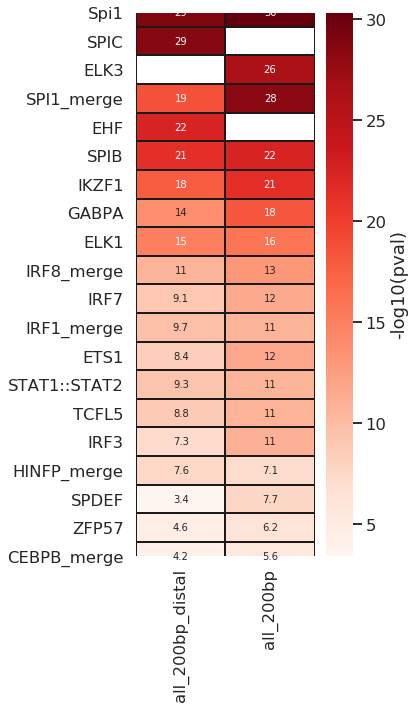

In [27]:
fig, ax = plt.subplots(figsize=(4,10))
# sort by new mean
tmp_frame = filtered_frame.reindex(
    filtered_frame.mean(axis=1).sort_values(ascending=False).index.tolist())


sns.heatmap(
    tmp_frame.head(20),
    cmap='Reds',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # col_cluster=False,
    # square=True,
    # center=0,
    ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26']
    )

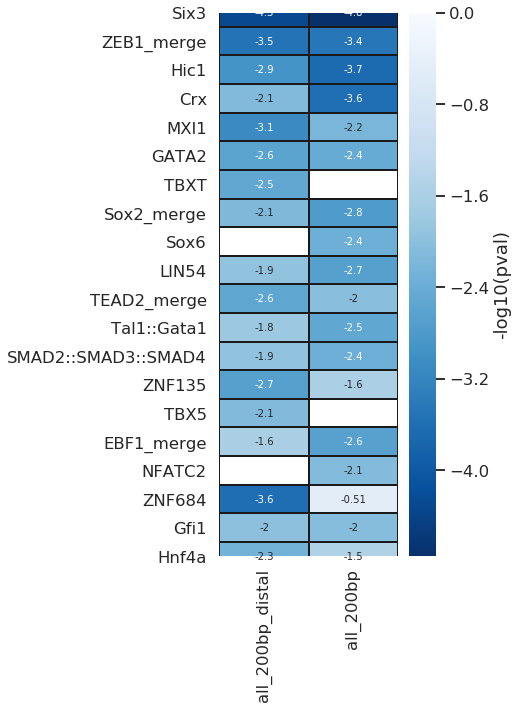

In [37]:
fig, ax = plt.subplots(figsize=(4,10))
# sort by new mean
tmp_frame = filtered_frame.reindex(
    filtered_frame.mean(axis=1).sort_values(ascending=True).index.tolist())


sns.heatmap(
    tmp_frame.head(20),
    cmap='Blues_r',
    linewidths=1,
    linecolor='k',
    annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # col_cluster=False,
    # square=True,
    vmax=0,
    ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26']
    )

# Plot motifs horizontally

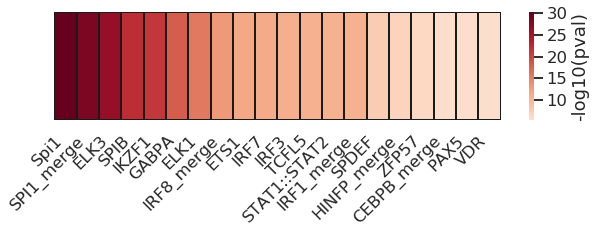

In [35]:
fig, ax = plt.subplots(figsize=(10,2))

filtered_frame = filtered_frame.sort_values('all_200bp', ascending=False)

cm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp']].iloc[:20, :].T,
    cmap='RdBu_r',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    ax=ax)

ax.set_xticklabels(filtered_frame.index.tolist()[:20], rotation=45, ha='right')
ax.set_yticklabels('', rotation=0, ha='center')

plt.savefig('./figures/maggie_distal_activated_motifs_merged_all.png', bbox_inches='tight')

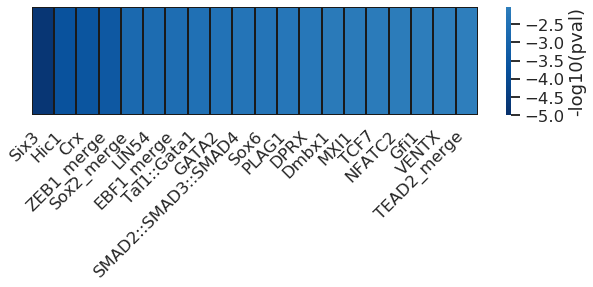

In [36]:
fig, ax = plt.subplots(figsize=(10,2))

filtered_frame = filtered_frame.sort_values('all_200bp', ascending=True)

cm = sns.heatmap(
    filtered_frame.loc[:, ['all_200bp']].iloc[:20, :].T,
    cmap='Blues_r',
    linewidths=1,
    linecolor='k',
    # annot=True,
    cbar_kws={'label': '-log10(pval)'},
    # square=True,
    center=0,
    vmin=-5,
    ax=ax)

ax.set_xticklabels(filtered_frame.index.tolist()[:20], rotation=45, ha='right')
ax.set_yticklabels('', rotation=0, ha='center')

plt.savefig('./figures/maggie_distal_activated_inverse_motifs_merged_all.png', bbox_inches='tight')

In [14]:
rpkm = pd.read_csv('/gpfs/data01/glasslab/home/h1bennet/strains/data/RNA/HOMER.rawTPM.amln.txt', sep='\t')

# Look at TF Expression levels

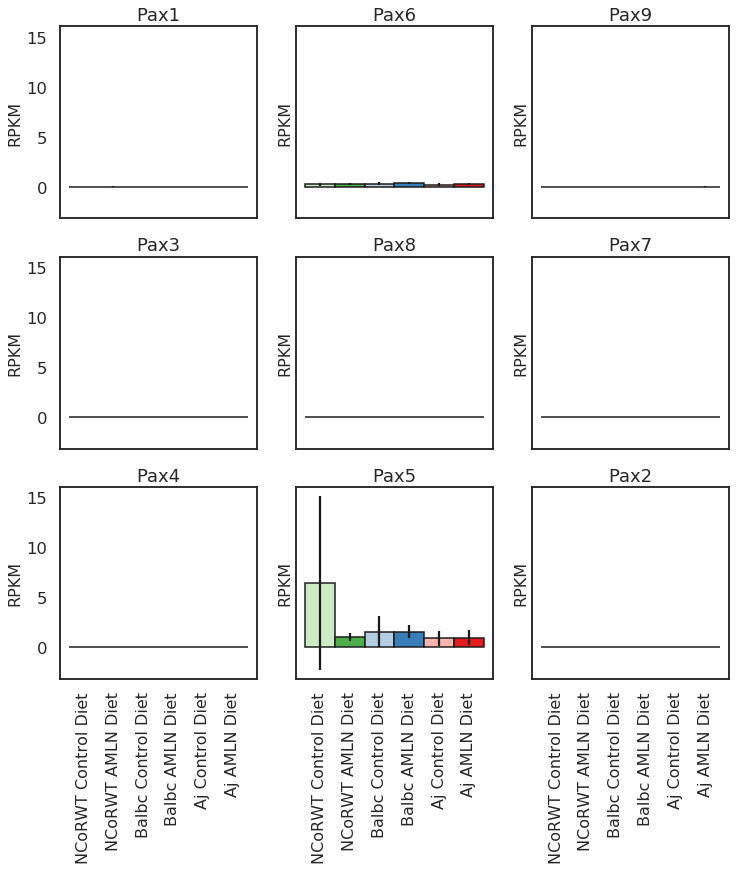

In [131]:
fig, axs = plt.subplots(3,3,figsize=(12,12), sharex=True, sharey=True)

count=0

for i in rpkm.loc[rpkm.index.str.contains('Pax[1-9]$'), :].index.tolist():
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

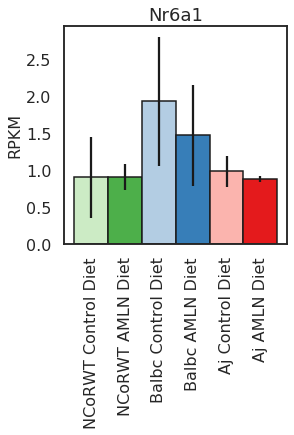

In [152]:
rpkm = survey_strain_amln_gene_exp('Nr6a1')

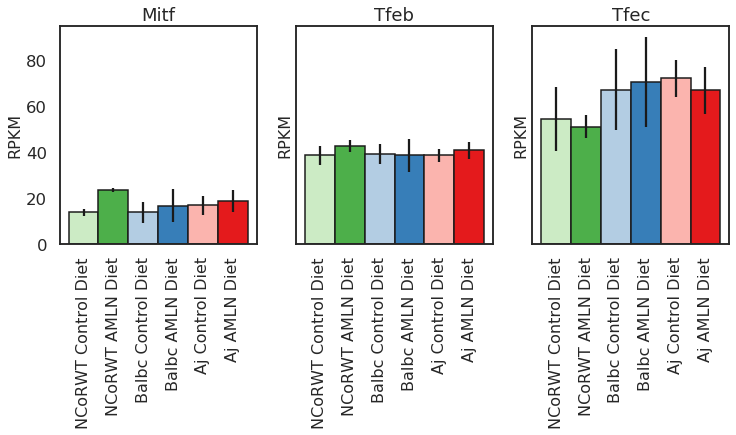

In [138]:
fig, axs = plt.subplots(1,3,figsize=(12,4), sharex=True, sharey=True)

count=0

for i in ['Mitf', 'Tfeb', 'Tfec']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

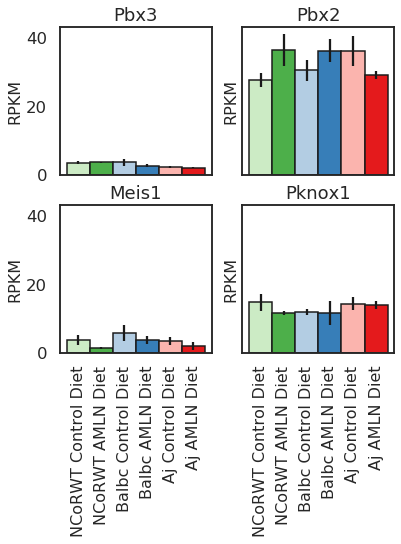

In [147]:
fig, axs = plt.subplots(2,2,figsize=(6,6), sharex=True, sharey=True)

count=0

for i in ['Pbx3', 'Pbx2', 'Meis1', 'Pknox1']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1

In [149]:
rpkm.loc[rpkm.index.str.contains('Bach'), :]

,chr,start,end,strand,Length,Copies,Annotation/Divergence,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12a_16_12_1,aj_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_AJ12b_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13a_JSSTDT_16_12_1,balbc_Tim4NegKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,balbc_Tim4PosKupffer_RNA_polyA_CCl4_6weeksNoRecovery_Balb13b_JSSTDT_16_12_1,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE1_CC1B_JSS_l20171006_GGTAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE2_CC1C_JSS_l20171006_ATGAG,mouse_C57Bl6_M_KupfferTim4Neg_RNA_polyA_CCl4sixWks_JSSTDTE3_CC1D_JSS_l20171006_ATTCC
gene,,,,,,,,,,,,,,,
Bach1,chr16,87698954,87733346,+,5851.0,1,Bach1|6230421P05Rik|AI323795|-|16|16 C3.3|prot...,42.284,47.377,38.528,52.811,30.577,40.853,39.973,40.023
Bach2os,chr4,32559680,32571662,-,1656.0,1,Bach2os|-|-|4|4 A5|ncRNA,39.409,36.493,44.942,33.432,28.295,55.059,41.474,48.139
Bach2,chr4,32417435,32586108,+,8486.0,1,Bach2|E030004N02Rik|-|4|4 A5|protein-coding,16.459,16.023,11.986,13.087,7.857,13.653,13.614,12.539


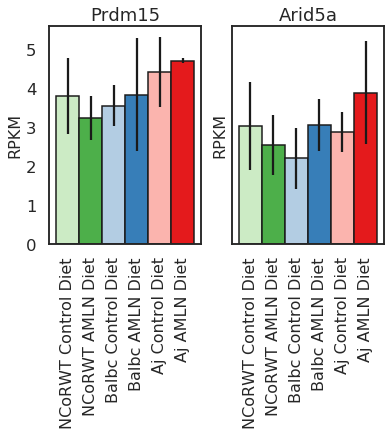

In [154]:
fig, axs = plt.subplots(1,2,figsize=(6,4), sharex=True, sharey=True)

count=0

for i in ['Prdm15', 'Arid5a']:
    survey_strain_gene_exp(i, ax=axs.flatten()[count])
    count+=1